# Smoking & Biological Aging — Comp 1 Analysis

**Author:** Emanuele Leoncini  
**Date:** September 28, 2025  
**Course:** Biolearn Fall 2025 – Harvard Aging Initiative  

---
## Description
This notebook investigates whether smoking is associated with accelerated epigenetic aging, defined as a greater DNAm age relative to chronological age. We compare never-smokers, former smokers, and current smokers using Biolearn’s epigenetic clock models to evaluate smoking-related differences in biological aging.

**Plan**
1. **Load & explore dataset** (document assumptions and data quality).
2. **Horvath v1**: compute acceleration; explain *simple* vs *residual*; test for group differences; conclude why it underperforms for smoking.
3. **GrimAge**: justify choice; compute accelerations; visualize (violins, ridge), and estimate group differences with CIs (Gardner–Altman style).
4. **Statistical inference**: permutation/Welch's t-tests, effect sizes, multiple testing.
5. **Conclusions**: quantify “how much older” former/current vs never, with uncertainty; discuss small-N caveats for current; briefly address “how to choose a clock.”

**Data:**
- `**GSE50660**`: publicly available whole-blood DNA methylation dataset (Illumina 450k array) with smoking status annotated. It includes never, former, and current smokers, enabling direct group comparisons.  
- `age`: chronological age (years)
- `smoking_status`: categorical in `{"never","former","current"}`
- `DNAmAge_HorvathV1`: Horvath 2013 multi-tissue clock age (years)
- `DNAmAge_GrimAge`: GrimAge estimate (years)

---
# Imports and functions

In [1]:
# === Libraries ===
# Biolearn
from biolearn.data_library import DataLibrary, GeoData  # assuming this exists in your install
from biolearn.model_gallery import ModelGallery

# Core
import numpy as np
import pandas as pd
import re
import os

# Stats
from scipy import stats
from itertools import combinations
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

In [2]:
# === Global settings ===
# Set directory for saving figures
save_dir = os.getcwd()   # current working directory, or replace with custom path
os.makedirs(save_dir, exist_ok=True)

# Reproducible random generator
RNG = np.random.default_rng(42)

# Plot settings
SMOKE_ORDER   = ["never", "former", "current"]
SMOKE_PALETTE = {"never": "#2ca02c",   # green
                 "former": "#b58900",  # dark yellow
                 "current": "#d62728"} # red

In [3]:
# === Plotting functions (uniform docstrings) ===

def plot_accel_violin(meta, y_col, title=None):
    """
    Plot age-acceleration by smoking group using a composite violin + box + scatter view.

    Parameters
    ----------
    meta : pd.DataFrame
        Table containing at least 'smoking_status' and the column specified by `y_col`.
        'smoking_status' may be string or categorical; order is taken from SMOKE_ORDER if present.
    y_col : str
        Column in `meta` to visualize (e.g., 'AgeAccel_Horvath_resid', 'AgeAccel_GrimAge_resid').
        Values should be numeric; NaNs are automatically ignored by seaborn.
    title : str, optional
        Custom figure title. If None, defaults to "{y_col} by smoking status".

    Returns
    -------
    matplotlib.axes.Axes
        The Axes for the violin layer (useful if you need to tweak after plotting).

    Notes
    -----
    - Violin shows the full distribution, box marks median/IQR, scatter overlays individual points.
    - A dashed horizontal line at 0 helps interpret residual acceleration (centered expectation).
    - Colors and group order come from global SMOKE_PALETTE / SMOKE_ORDER for consistency.

    Examples
    --------
    >>> plot_accel_violin(meta, "AgeAccel_GrimAge_resid", "GrimAge residual acceleration by smoking")
    """
    if "smoking_status" not in meta.columns:
        raise KeyError("meta must contain 'smoking_status'")
    if y_col not in meta.columns:
        raise KeyError(f"meta must contain '{y_col}'")

    # Respect global group order but only include groups actually present
    order = [g for g in SMOKE_ORDER if g in meta["smoking_status"].astype(str).unique()]

    fig = plt.figure(figsize=(8, 5))

    # Violin plot
    ax = sns.violinplot(
        data=meta, x="smoking_status", y=y_col,
        order=order, hue_order=order, dodge=False, cut=0, inner=None,
        palette=SMOKE_PALETTE, alpha=0.2, legend=False
    )

    # Boxplot
    sns.boxplot(
        data=meta, x="smoking_status", y=y_col,
        order=order, hue_order=order, dodge=False, width=0.2, showcaps=True,
        boxprops={"facecolor": "white", "alpha": 0.99},
        showfliers=False, whiskerprops={"linewidth": 1.5}, palette=SMOKE_PALETTE,
        legend=False
    )

    # Scatterplot
    sns.stripplot(
        data=meta, x="smoking_status", y=y_col,
        order=order, hue_order=order, dodge=False, alpha=0.3, jitter=0.12,
        palette=SMOKE_PALETTE, edgecolor="black", linewidth=0.3, zorder=3, legend=False
    )

    # Cleanup & labels
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    plt.axhline(0, ls="--", lw=1, color="grey", zorder=0)
    plt.xlabel("Smoking status"); plt.ylabel("Age acceleration (years)")
    plt.title(title if title else f"{y_col} by smoking status")
    plt.tight_layout()
    return fig, ax




def plot_accel_ridgeline(meta, y_col, title=None):
    """
    Plot stacked (ridgeline-style) KDEs of age-acceleration by smoking group.

    Parameters
    ----------
    meta : pd.DataFrame
        Table containing at least 'smoking_status' and the column specified by `y_col`.
    y_col : str
        Column in `meta` to visualize (e.g., 'AgeAccel_GrimAge_resid').
        Values should be numeric; NaNs are dropped per group.
    title : str, optional
        Custom figure title. If None, defaults to "Ridgeline densities — {y_col}".

    Returns
    -------
    None
        Displays the figure.

    Notes
    -----
    - Each row shows the kernel density estimate for one group, using SMOKE_PALETTE colors.
    - The dashed vertical line at 0 is a visual reference: for residual acceleration,
      zero means “as expected given chronological age.”
    - This view complements violins by emphasizing shape and potential multimodality.

    Examples
    --------
    >>> plot_accel_ridgeline(meta, "AgeAccel_GrimAge_resid",
    ...                      "Distribution of residual acceleration by smoking (GrimAge)")
    """
    if "smoking_status" not in meta.columns:
        raise KeyError("meta must contain 'smoking_status'")
    if y_col not in meta.columns:
        raise KeyError(f"meta must contain '{y_col}'")

    # Respect global group order while including present groups
    order = [g for g in SMOKE_ORDER if g in meta["smoking_status"].astype(str).unique()]

    # One density row per group
    fig, axes = plt.subplots(len(order), 1, figsize=(7, 1.3 * len(order)), sharex=True)
    if len(order) == 1:
        axes = [axes]

    for i, grp in enumerate(order):
        ax = axes[i]
        sub = meta.loc[meta["smoking_status"].astype(str) == grp, y_col].dropna()
        if len(sub) == 0:
            continue
        # Filled KDE
        sns.kdeplot(x=sub, fill=True, alpha=0.5, color=SMOKE_PALETTE[grp], ax=ax)
        ax.axvline(0, ls="--", color="grey", lw=1)  
        ax.set_yticks([])                           
        ax.set_ylabel(grp)
        if i < len(order) - 1:
            ax.set_xlabel("")

    axes[-1].set_xlabel("Residual DNAm age acceleration (years)")
    fig.suptitle(title if title else f"Ridgeline densities — {y_col}", y=1.02, fontsize=12)
    plt.tight_layout()

    return fig, axes




def plot_gardner_altman(meta, y_col, ref="never", comps=("former","current"),
                        title=None, B=5000, seed=42, legend_out=True):
    """
    Gardner-Altman estimation plot for group differences vs a reference.

    Left panel: raw data per group (box + scatter) with a zero line for residuals.
    Right panel: bootstrap distribution of mean differences Δ = mean(comp) - mean(ref),
    with observed Δ and 95% CI marked. Legend explains the comparisons.

    Parameters
    ----------
    meta : pd.DataFrame
        Must contain 'smoking_status' and the column specified by y_col.
    y_col : str
        Column to analyze (e.g., 'AgeAccel_GrimAge_resid'). Falls back to 'AgeAccelGrim_resid' if present.
    ref : str, default="never"
        Reference group label.
    comps : tuple[str, ...], default=("former","current")
        Groups to compare against the reference.
    title : str, optional
        Figure title (placed as a suptitle).
    B : int, default=5000
        Number of bootstrap resamples for Δ (larger → smoother KDE and tighter CI).
    seed : int, default=42
        RNG seed for reproducibility of bootstrap resampling.
    legend_out : bool, default=True
        If True, place the legend to the right of the density panel.

    Returns
    -------
    None
        Displays the figure.
    """
    # Column presence (accept common alternative for GrimAge residual)
    if y_col not in meta.columns:
        alt = "AgeAccelGrim_resid"
        if alt in meta.columns:
            y_col = alt
        else:
            raise KeyError(f"Column '{y_col}' not found in meta.")

    rng = np.random.default_rng(seed)  # local RNG (keeps function self-contained)
    order = [g for g in SMOKE_ORDER if g in meta["smoking_status"].astype(str).unique()]

    # Data split
    y = meta[y_col]; g = meta["smoking_status"].astype(str)
    ref_vals = y[g == ref].dropna().to_numpy()

    # Bootstrap helper: returns B bootstrapped mean differences
    def boot_diff(a, b, B=5000):
        ai = rng.integers(0, len(a), (B, len(a)))  # indices for a
        bi = rng.integers(0, len(b), (B, len(b)))  # indices for b
        return a[ai].mean(1) - b[bi].mean(1)

    # Compute Δ and 95% CI for each comparison vs ref
    boot, obs, ci = {}, {}, {}
    for comp in comps:
        comp_vals = y[g == comp].dropna().to_numpy()
        if len(comp_vals) < 3 or len(ref_vals) < 3:
            continue
        boot[comp] = boot_diff(comp_vals, ref_vals, B=B)
        obs[comp]  = comp_vals.mean() - ref_vals.mean()
        ci[comp]   = np.percentile(boot[comp], [2.5, 97.5])

    # Figure layout
    fig = plt.figure(figsize=(11.5, 4))
    gs  = fig.add_gridspec(1, 2, width_ratios=[1.25, 1.25])

    # Left: raw data per group (distribution + central tendency)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.boxplot(
        data=meta, x="smoking_status", y=y_col,
        order=order, hue_order=order, dodge=False,
        showcaps=True, showfliers=False,
        boxprops={"facecolor": "white", "alpha": 0.99},
        whiskerprops={"linewidth": 1.5}, palette=SMOKE_PALETTE,
        legend=False, ax=ax1
    )
    sns.stripplot(
        data=meta, x="smoking_status", y=y_col,
        order=order, hue_order=order, dodge=False,
        palette=SMOKE_PALETTE, alpha=0.3, jitter=0.12,
        edgecolor="black", linewidth=0.3, legend=False, ax=ax1
    )
    if ax1.get_legend(): ax1.get_legend().remove()
    ax1.axhline(0, ls="--", lw=1, color="grey")
    ax1.set_xlabel("Smoking status"); ax1.set_ylabel("Residual DNAm age acceleration (years)")
    ax1.set_title("Raw data")

    # Right: bootstrap density of Δ with observed Δ and CI lines
    ax2 = fig.add_subplot(gs[0, 1])
    labels = []
    for comp in comps:
        if comp in boot:
            sns.kdeplot(x=boot[comp], fill=True, alpha=0.35, color=SMOKE_PALETTE[comp],
                        label=f"{comp} − {ref}", ax=ax2)
            ax2.axvline(obs[comp], color=SMOKE_PALETTE[comp], lw=2)          # observed Δ
            ax2.axvline(ci[comp][0], ls="--", color=SMOKE_PALETTE[comp], lw=1)  # 95% CI low
            ax2.axvline(ci[comp][1], ls="--", color=SMOKE_PALETTE[comp], lw=1)  # 95% CI high
            labels.append(f"{comp} - {ref}")

    # Legend (explicit color patches so colors are correct)
    handles = [Patch(facecolor=SMOKE_PALETTE[c], alpha=0.35, edgecolor="none")
               for c in comps if c in boot]
    if legend_out:
        ax2.legend(handles, labels, frameon=False, title="Δ = mean(comp) - mean(ref)",
                   loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.0)
        plt.subplots_adjust(right=0.82)
    else:
        ax2.legend(handles, labels, frameon=False, title="Δ = mean(comp) - mean(ref)")

    # Δ and 95% CI text (two lines, readable)
    name_map = {"former": "Former", "current": "Current", "never": "Never"}
    lines = []
    for comp in comps:
        if comp in obs:
            lines.append(
                f"Δ{name_map.get(comp, comp)} = {obs[comp]:.2f}  ||  95% CI: [{ci[comp][0]:.2f}, {ci[comp][1]:.2f}]"
            )
    ax2.axvline(0, color="grey", ls="--", lw=1)
    ax2.set_xlabel(f"Mean difference vs {ref} (years)")
    ax2.set_title("\n".join(lines))

    if title:
        fig.suptitle(title, y=1.02, fontsize=12)
    plt.tight_layout()

    return fig, (ax1, ax2)


In [4]:
# === Statistical testing function ===
def compare_groups_welch(meta, y_col, groups=None, alpha=0.05,
                         B_boot=5000, B_perm=10000, adjust="holm"):
    """
    Pairwise comparisons between smoking groups on a given metric (e.g., residual acceleration).

    For each pair, computes:
      • Welch's t-test p-value (unequal variances, robust to unequal n)
      • Permutation p-value for the mean difference (non-parametric)
      • Bootstrap 95% CI for the mean difference
      • Cliff's delta (non-parametric effect size; positive means first group > second)

    Parameters
    ----------
    meta : pd.DataFrame
        Must contain 'smoking_status' and the numeric column specified by `y_col`.
    y_col : str
        Column to analyze (e.g., 'AgeAccel_Horvath_resid', 'AgeAccel_GrimAge_resid').
    groups : list[str], optional
        Subset/order of groups to compare. Defaults to groups from SMOKE_ORDER that are present.
    alpha : float, default=0.05
        Significance level used for multiple-testing correction (if enabled).
    B_boot : int, default=5000
        Number of bootstrap resamples for CI of mean difference.
    B_perm : int, default=10000
        Number of permutations for permutation p-value.
    adjust : {"holm","none"}, default="holm"
        Multiple-testing correction applied to permutation p-values across all pairs.

    Returns
    -------
    pd.DataFrame
        One row per pair with sample sizes, mean difference, 95% CI, Welch p, permutation p,
        Cliff's delta, and (optionally) Holm thresholds + rejection decisions.

    Notes
    -----
    - Welch's t-test is preferred here due to unequal variances/sample sizes across groups.
    - Mean difference is reported as mean(group1) - mean(group2).
    - Cliff's delta ∈ [-1, 1]; |delta| ~ 0.11 small, ~0.28 medium, ~0.43 large (rough heuristics).
    - Uses your existing helpers: bootstrap_ci_mean_diff, permutation_test_mean_diff, cliffs_delta, holm_bonferroni.

    Examples
    --------
    >>> res_h = compare_groups_welch(meta, "AgeAccel_Horvath_resid")
    >>> res_g = compare_groups_welch(meta, "AgeAccel_GrimAge_resid", adjust="holm")
    """
    # Basic checks
    if "smoking_status" not in meta.columns:
        raise KeyError("meta must contain 'smoking_status'")
    if y_col not in meta.columns:
        raise KeyError(f"meta must contain '{y_col}'")

    # Default group list: respect global order but include only present groups
    if groups is None:
        present = meta["smoking_status"].astype(str).unique().tolist()
        groups = [g for g in SMOKE_ORDER if g in present]

    rows = []
    # Iterate over all unordered pairs (g1 vs g2)
    for g1, g2 in combinations(groups, 2):
        a = meta.loc[meta["smoking_status"] == g1, y_col].astype(float).dropna().to_numpy()
        b = meta.loc[meta["smoking_status"] == g2, y_col].astype(float).dropna().to_numpy()

        # Require minimal sample size in each group
        if len(a) < 3 or len(b) < 3:
            continue

        # Welch's t-test (equal_var=False)
        t_stat, p_welch = stats.ttest_ind(a, b, equal_var=False)

        # Mean difference and non-parametric inference
        mdiff = float(np.mean(a) - np.mean(b))
        ci_lo, ci_hi = bootstrap_ci_mean_diff(a, b, B=B_boot, ci=95)  # bootstrap CI
        _, p_perm = permutation_test_mean_diff(a, b, B=B_perm)        # permutation p-value
        cd = cliffs_delta(a, b)                                       # effect size

        rows.append({
            "comparison": f"{g1} vs {g2}",
            "n1": len(a), "n2": len(b),
            "mean_diff": mdiff,
            "CI95_lo": ci_lo, "CI95_hi": ci_hi,
            "Welch_p": p_welch,
            "Perm_p": p_perm,
            "Cliffs_delta": cd,
        })

    res = pd.DataFrame(rows)

    if res.empty:
        return res

    # Rounding for readability (keep raw in separate df if you need exacts)
    res = res.assign(
        mean_diff=lambda d: d["mean_diff"].round(3),
        CI95_lo=lambda d: d["CI95_lo"].round(3),
        CI95_hi=lambda d: d["CI95_hi"].round(3),
        Welch_p=lambda d: d["Welch_p"].round(4),
        Perm_p=lambda d: d["Perm_p"].round(4),
        Cliffs_delta=lambda d: d["Cliffs_delta"].round(3),
    )

    # Optional multiple-testing adjustment (Holm on permutation p-values)
    if adjust.lower() == "holm":
        thr, rej = holm_bonferroni(res["Perm_p"].tolist(), alpha=alpha)
        res["Holm_thresh"] = [round(t, 4) for t in thr]
        res["Reject@alpha"] = rej

    return res


In [5]:
# === Utility Functions ===
def cliffs_delta(x, y):
    """
    Cliff's delta effect size for two independent samples.

    Returns
    -------
    float
        δ in [-1, 1]. Positive means x > y more often than y > x.
    Notes
    -----
    - Exact O(n_x * n_y) comparison; falls back to random subsampling if >2e6 pairs.
    """
    x = np.asarray(x); y = np.asarray(y)
    n = len(x)*len(y)
    if n > 2_000_000:
        m = 2_000_000
        xi = RNG.integers(0, len(x), m)
        yi = RNG.integers(0, len(y), m)
        diff = x[xi] - y[yi]
        return (np.sum(diff > 0) - np.sum(diff < 0)) / m
    diff = x[:, None] - y[None, :]
    return (np.sum(diff > 0) - np.sum(diff < 0)) / n


def permutation_test_mean_diff(a, b, B=10000):
    """
    Two-sided permutation test for difference in means.

    Parameters
    ----------
    a, b : array-like
        Samples for groups A and B.
    B : int
        Number of permutations.

    Returns
    -------
    (obs, p) : (float, float)
        obs = mean(a) - mean(b), p = permutation p-value (two-sided).
    """
    a = np.asarray(a); b = np.asarray(b)
    z = np.r_[a, b].copy()
    n = len(a)
    obs = a.mean() - b.mean()
    ge = 0
    for _ in range(B):
        RNG.shuffle(z)
        if abs(z[:n].mean() - z[n:].mean()) >= abs(obs):
            ge += 1
    p = (ge + 1)/(B + 1)
    return obs, p


def bootstrap_ci_mean_diff(a, b, B=5000, ci=95):
    """
    Bootstrap CI for mean(a) - mean(b) using percentile method.

    Parameters
    ----------
    a, b : array-like
        Samples for groups A and B.
    B : int
        Bootstrap resamples.
    ci : int
        Confidence level (e.g., 95).

    Returns
    -------
    (lo, hi) : (float, float)
        Lower and upper CI bounds.
    """
    a = np.asarray(a); b = np.asarray(b)
    ai = RNG.integers(0, len(a), (B, len(a)))
    bi = RNG.integers(0, len(b), (B, len(b)))
    diffs = a[ai].mean(1) - b[bi].mean(1)
    lo, hi = np.percentile(diffs, [(100-ci)/2, 100-(100-ci)/2])
    return lo, hi


def holm_bonferroni(pvals, alpha=0.05):
    """
    Holm–Bonferroni step-down adjustment thresholds and rejections.

    Parameters
    ----------
    pvals : list[float]
        Unadjusted p-values across multiple tests.
    alpha : float
        Familywise error rate.

    Returns
    -------
    (thresh, reject) : (list[float], list[bool])
        Per-test Holm threshold and boolean reject decision.
    """
    m = len(pvals)
    order = np.argsort(pvals)
    rejs = [False]*m; thresh = [None]*m
    for k, idx in enumerate(order, start=1):
        t = alpha/(m - k + 1)
        thresh[idx] = t
        rejs[idx] = pvals[idx] <= t
    return thresh, rejs


---
# Smoking and Biological Age

We use DNA methylation data from **GSE50660** to investigate how smoking influences the pace of biological aging.  
Biolearn’s epigenetic clocks are applied to compute **age acceleration**, comparing epigenetic vs. chronological age across three groups:  
- **Never smokers**  
- **Former smokers**  
- **Current smokers**  

Our goal is to test whether smoking status is associated with accelerated biological aging and to assess which epigenetic clock provides the most informative signal.

---
## Dataset operations

---
### Load dataset

In [6]:
# === Load dataset: GSE50660 ===
dl = DataLibrary()
data = dl.get("GSE50660").load() 

meta = data.metadata.copy()
dnam = data.dnam.copy()

print("Metadata shape:", meta.shape)
print("Methylation matrix shape:", dnam.shape)

print("\nMetadata columns:", list(meta.columns))

print("\n---> Metadata <---")
display(meta.head())

print("\n---> Methylation values <---")
display(dnam.iloc[:5, :5])  # show only first 5x5 to avoid huge output

Metadata shape: (464, 4)
Methylation matrix shape: (482739, 464)

Metadata columns: ['smoking_(0,_1_and_2,_which_represent_never,_former_and_current_smokers)', 'age', 'sex', 'tissue']

---> Metadata <---


,"smoking_(0,_1_and_2,_which_represent_never,_former_and_current_smokers)",age,sex,tissue
id,,,,
GSM1225377,1,50.0,2,blood
GSM1225378,0,56.0,2,blood
GSM1225379,1,49.0,1,blood
GSM1225380,1,64.0,2,blood
GSM1225381,1,51.0,2,blood



---> Methylation values <---


,GSM1225377,GSM1225378,GSM1225379,GSM1225380,GSM1225381
id,,,,,
cg00000029,0.49084,0.49592,0.57631,0.57863,0.55712
cg00000108,0.92244,0.94084,0.90422,0.89988,0.94066
cg00000109,0.88327,0.88991,0.85715,0.88534,0.85857
cg00000165,0.18253,0.20281,0.20437,0.18704,0.21079
cg00000236,0.71851,0.70238,0.75614,0.69475,0.78757


---
### Process dataset
Edit dataframes to ready them for subsequent analyses.

In [7]:
# === Metadata ===
meta = data.metadata.copy()

# Find the smoke-column
smoke_col = next(c for c in meta.columns if re.search(r"^smoking", c, flags=re.I))

# Coerce to integer codes
meta[smoke_col] = pd.to_numeric(meta[smoke_col], errors="coerce").astype("Int64")
meta = meta.rename(columns={smoke_col: "smoking_code"})

# Map to categorical labels
code2label = {0: "never", 1: "former", 2: "current"}
meta["smoking_status"] = (
    meta["smoking_code"].map(code2label)
    .astype(pd.CategoricalDtype(categories=["never","former","current"], ordered=True))
)

# Quick summary
print("=== Smoking status summary ===")
print(meta["smoking_status"].value_counts(dropna=False))
print("n =", meta["smoking_status"].notna().sum(), "with smoking info")

print("\n---> Updated Metadata <---")
display(meta.head(10))

=== Smoking status summary ===
smoking_status
former     263
never      179
current     22
Name: count, dtype: int64
n = 464 with smoking info

---> Updated Metadata <---


,smoking_code,age,sex,tissue,smoking_status
id,,,,,
GSM1225377,1,50.0,2,blood,former
GSM1225378,0,56.0,2,blood,never
GSM1225379,1,49.0,1,blood,former
GSM1225380,1,64.0,2,blood,former
GSM1225381,1,51.0,2,blood,former
GSM1225382,1,50.0,2,blood,former
GSM1225383,1,47.0,2,blood,former
GSM1225384,1,46.0,2,blood,former
GSM1225385,1,50.0,1,blood,former


In [8]:
# === DNAM (Methylation) ===

# Create dnam DataFrame
dnam = data.dnam.copy()
dnam.columns = dnam.columns.astype(str)  # ensure sample IDs are strings

# Coerce values to numeric
dnam = dnam.apply(pd.to_numeric, errors="coerce")

# Verify values ranges are within [0,1]
vmin = float(dnam.min(skipna=True).min()) if not dnam.empty else float("nan")
vmax = float(dnam.max(skipna=True).max()) if not dnam.empty else float("nan")
out_low  = int((dnam < 0).sum().sum())
out_high = int((dnam > 1).sum().sum())

print(f"dnam shape (CpGs x samples): {dnam.shape}")
print(f"methylation (β-value) range (ignoring NaN): {vmin} - {vmax}")
print(f"Out-of-range counts: <0 → {out_low}, >1 → {out_high}")

# Look for NaN values within dnam
na_total = int(dnam.isna().sum().sum())
print(f"Total missing values: {na_total:,}")

dnam shape (CpGs x samples): (482739, 464)
methylation (β-value) range (ignoring NaN): 0.00239 - 0.9976
Out-of-range counts: <0 → 0, >1 → 0
Total missing values: 0


---
### Align metadata and methylation samples

The metadata (`meta`) and methylation matrix (`dnam`) must refer to the **same set of samples** in the same order to prevent downstream mismatches.
- We coerce IDs to be strings in both the meta and dnam dataframes.  
- We then identify the **intersection** of sample IDs present in both datasets.  
- Finally, we subset and reorder `meta` and `dnam` to ensure perfect alignment.  

In [9]:
# === Align metadata and methylation IDs ===
meta.index = meta.index.astype(str)
dnam.columns = dnam.columns.astype(str)

common_ids = dnam.columns.intersection(meta.index)

print(f"Metadata samples: {len(meta)}")
print(f"Methylation samples: {dnam.shape[1]}")
print(f"Overlap: {len(common_ids)}")

# Subset and reorder to common IDs
meta = meta.loc[common_ids]
dnam = dnam[common_ids]

# Wrap metadata + methylation into a GeoData object
dataset = GeoData(meta, dnam)
print("\nGeoData object created:")
print(dataset)

Metadata samples: 464
Methylation samples: 464
Overlap: 464

GeoData object created:


---
## Run Biolearn clock models & compute age acceleration

With the dataset prepared and aligned, we now apply Biolearn’s **epigenetic clock models** to estimate DNA methylation ages.  
Two clocks are considered:  

- **Horvath v1 (2013 multi-tissue clock)** — optimized for chronological age across tissues.  
- **GrimAge** — incorporates DNAm surrogates (including smoking pack-years) and predicts mortality risk.  

For each clock, we derive **age acceleration** measures that quantify whether a sample’s epigenetic age is older or younger than expected given its chronological age:  

**1) Simple acceleration**

$$
\mathrm{Accel}_{\text{simple},i}
= \widehat{\mathrm{Age}}_{\mathrm{epi},i}
- \mathrm{Age}_{\mathrm{chrono},i}
$$

**2) Residual acceleration (age-adjusted)**  

Epigenetic age is naturally correlated with chronological age: older individuals tend to have higher DNAm ages. If two groups (e.g. smokers vs never-smokers) have different age distributions, a simple difference (used for the Simple acceleration) can be misleading — group differences might reflect age imbalance rather than true acceleration. To correct for this, we fit a **linear regression model** across all samples using **Ordinary Least Squares (OLS)**:

$$
\widehat{\mathrm{Age}}_{\mathrm{epi},i}
= \alpha + \beta \cdot \mathrm{Age}_{\mathrm{chrono},i} + \varepsilon_i
$$

Here:  
- $\alpha$ is the intercept,  
- $\beta$ is the slope (expected change in DNAm age per year of chronological age),  
- $\varepsilon_i$ is the residual (what’s left unexplained by age).  

We then define **residual acceleration** as exactly those residuals:

$$
\mathrm{Accel}_{\text{resid},i}
= \hat{\varepsilon}_i
= \widehat{\mathrm{Age}}_{\mathrm{epi},i}
- (\alpha + \beta \cdot \mathrm{Age}_{\mathrm{chrono},i})
$$

This residual acceleration represents how much older or younger someone appears epigenetically **after accounting for their chronological age trend** — making it a fairer measure of smoking-related differences.

---
### Clock: Horvath v1

To quantify biological aging from DNA methylation, we first apply the **Horvath multi-tissue epigenetic clock** (Horvath, 2013).  

Key features:  
- Trained across multiple tissues and cell types → broadly applicable to whole-blood data such as **GSE50660**.  
- Outputs **DNAm age** in calendar years, directly comparable to chronological age.  
- Provides a baseline measure of **age acceleration**, defined as:  

$$
\mathrm{AgeAccel} = \widehat{\mathrm{DNAmAge}} - \mathrm{Age}_{\text{chrono}}
$$

We will compute both **simple** and **residual** acceleration (as defined above), and then stratify these values by **smoking status** (never, former, current) to test whether smoking is associated with accelerated biological aging.

In [10]:
# === Horvath v1 clock ===

# Load Horvath v1 model from Biolearn gallery
clock = ModelGallery().get("Horvathv1")

# Predict DNAm age (aligned to meta.index)
dnam_age = clock.predict(dataset)

# Attach to metadata for convenience
meta["DNAmAge_Horvathv1"] = dnam_age

print("\n---> Meta (update): Horvath v1 DNAm ages <---")
display(meta.head())


---> Meta (update): Horvath v1 DNAm ages <---


,smoking_code,age,sex,tissue,smoking_status,DNAmAge_Horvathv1
GSM1225377,1,50.0,2,blood,former,53.788850
GSM1225378,0,56.0,2,blood,never,56.558477
GSM1225379,1,49.0,1,blood,former,42.674684
GSM1225380,1,64.0,2,blood,former,57.529693
GSM1225381,1,51.0,2,blood,former,44.900505


---
#### Simple age acceleration (Horvath v1)

We start with the **simple definition** of age acceleration:

$$
\mathrm{Accel}_{\text{simple}} = \widehat{\mathrm{DNAmAge}} - \mathrm{Age}_{\text{chrono}}
$$

This captures the raw difference between Horvath DNAm age and chronological age for each sample. 

On average, the differences across smoking groups are very small for (simple) acceleration.

In [11]:
# === Simple age acceleration (Horvath v1) ===

# Compute simple acceleration: DNAm age - chronological age
meta["AgeAccel_Horvath_simple"] = meta["DNAmAge_Horvathv1"] - pd.to_numeric(meta["age"], errors="coerce")

# Preview
meta[["age", "DNAmAge_Horvathv1", "AgeAccel_Horvath_simple", "smoking_status"]].head()

# Correlation between DNAm age and chronological age
r = meta[["age", "DNAmAge_Horvathv1"]].dropna().corr().iloc[0, 1]
print(f"Correlation (Horvath v1 DNAmAge vs chronological age): r = {r:.3f}")

# Group summary of simple acceleration
print("\n---> Horvath v1 simple age acceleration by smoking status <---")
display(
    meta.groupby("smoking_status")["AgeAccel_Horvath_simple"]
        .agg(n="count", mean="mean", sd="std")
        .round(3)
)

Correlation (Horvath v1 DNAmAge vs chronological age): r = 0.766

---> Horvath v1 simple age acceleration by smoking status <---


/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3176567646.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meta.groupby("smoking_status")["AgeAccel_Horvath_simple"]


,n,mean,sd
smoking_status,,,
never,179,-0.475,4.124
former,263,-0.575,4.848
current,22,-1.048,4.221


---
#### Residual age acceleration (Horvath v1)

While simple acceleration gives the raw difference between DNAm age and chronological age, it can still reflect group age imbalances masking the effect we're trying to observe. We want therefore to correct for this bias, and see if with this change we can observe a more significant difference across classes than what we measured above. 

To correct for this, we compute **residual acceleration** by fitting a linear regression of DNAm age on chronological age across all samples:
$$
\widehat{\mathrm{DNAmAge}}_i
= \alpha + \beta \cdot \mathrm{Age}_{\mathrm{chrono},i} + \varepsilon_i
$$

The **residuals** ($\hat{\varepsilon}_i$) from this model represent how much older or younger each sample appears epigenetically **after accounting for the expected effect of age**:

$$
\mathrm{AgeAccel}_{\text{resid},i}
= \widehat{\mathrm{DNAmAge}}_i - (\alpha + \beta \cdot \mathrm{Age}_{\mathrm{chrono},i})
$$

This adjustment removes the linear age trend and makes comparisons across smoking groups more reliable. On average, though, the residual values remain close to zero, again showing minimal differences across groups.


In [12]:
# === Residual age acceleration (Horvath v1) ===
df = meta[["DNAmAge_Horvathv1", "age"]].dropna().copy()

# Create array with intercept and slope (to estimate alpha + beta Age):
X = np.c_[np.ones(len(df)), pd.to_numeric(df["age"], errors="coerce").to_numpy()]
# Dependent variable: DNAm age
y = pd.to_numeric(df["DNAmAge_Horvathv1"], errors="coerce").to_numpy()
# OLS estimation:
beta, *_ = np.linalg.lstsq(X, y, rcond=None)
resid = y - X @ beta  # residuals = AgeAccel_resid

meta.loc[df.index, "AgeAccel_Horvath_resid"] = resid.astype(float)

# Group summary (use meta, which still has smoking_status)
print("\n---> Horvath v1 residual age acceleration by smoking status <---")
display(
    meta.loc[df.index]
        .groupby("smoking_status")["AgeAccel_Horvath_resid"]
        .agg(n="count", mean="mean", sd="std")
        .round(3)
)


---> Horvath v1 residual age acceleration by smoking status <---


/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/227551056.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("smoking_status")["AgeAccel_Horvath_resid"]


,n,mean,sd
smoking_status,,,
never,179,0.096,3.796
former,263,0.002,4.615
current,22,-0.800,3.251


---
#### Visualizing residual acceleration (Horvath v1)

To assess whether Horvath v1 captures smoking-related differences, we visualize the **residual age acceleration** across smoking groups. We focus on residual acceleration provided it should correct for systemic offsets.

- **Violin + box + scatterplot**: shows the distribution, median, and individual data points for each group, making it easy to compare central tendency and spread.  
- **Stacked density plots (ridgelines)**: show the full shape of the distributions stacked by group, highlighting whether any group is systematically shifted above or below zero.  

Residual acceleration values are centered around zero, so the dashed line marks the expected epigenetic age given chronological age. Any consistent upward or downward shift by group would indicate accelerated or decelerated biological aging.

These plots confirm the earlier numerical results: residual acceleration remains close to zero for all groups, with no systematic shift by smoking status.

/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/1594400412.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot 

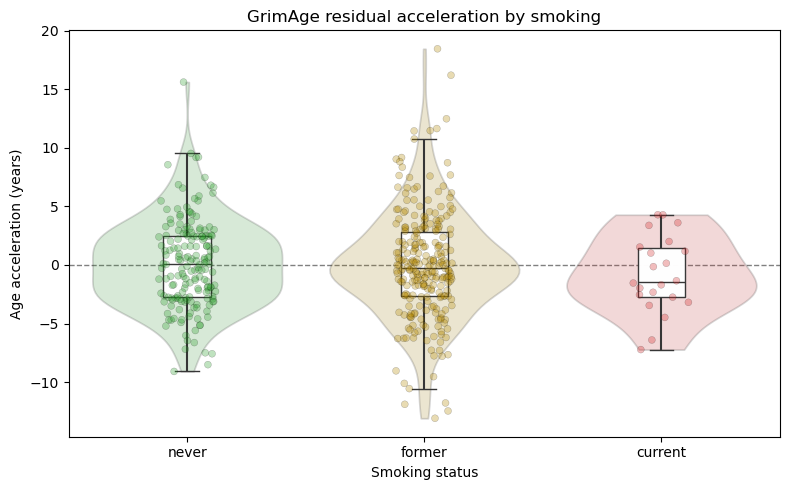

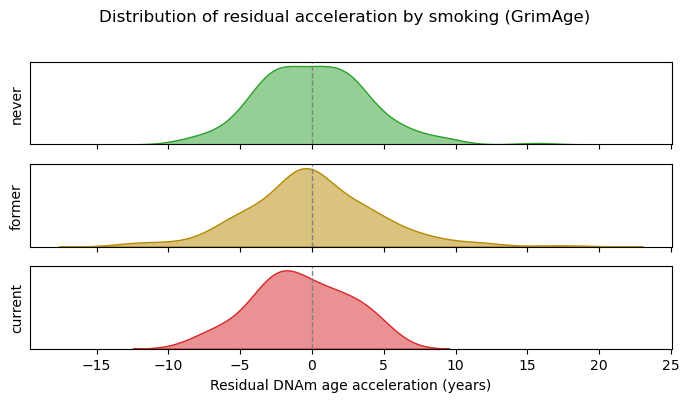

In [13]:
# Violin + box + scatter
fig, ax = plot_accel_violin(
    meta, "AgeAccel_Horvath_resid", "GrimAge residual acceleration by smoking"
)
fig.savefig(os.path.join(save_dir, "grim_violin.png"), dpi=300, bbox_inches="tight")
fig.show()

# Ridgeline densities
fig, axes = plot_accel_ridgeline(
    meta, "AgeAccel_Horvath_resid", "Distribution of residual acceleration by smoking (GrimAge)"
)
fig.savefig(os.path.join(save_dir, "grim_ridgeline.png"), dpi=300, bbox_inches="tight")
fig.show()

---
#### Statistical tests (Horvath v1)

To formally test for group differences in Horvath v1 residual acceleration, we compare smoking groups pairwise using **Welch’s t-test**.  

We choose Welch’s version rather than the standard Student’s t-test because the group sizes are very unbalanced in this dataset (never = 179, former = 263, current = 22). Welch’s test does not assume equal variances and is more reliable under unequal group sizes and variances than the standard t-test.  

As expected from both the numerical values and the plots, neither the simple nor the residual acceleration measures show significant differences between smoking groups. In the Welch’s t-test results below, the mean differences between groups are small and the confidence intervals cross zero, while the p-values remain large. Together, this indicates that any observed differences are minor relative to within-group variability. This reinforces that Horvath v1, designed to track chronological age, is not sensitive to smoking-related biological aging.

This statistical test provides a final confirmation: Horvath v1, designed to track chronological age, is not sensitive to smoking-related biological aging.

In [14]:
# === Horvath v1: statistical tests (simple vs residual acceleration) ===
res_horvath = compare_groups_welch(meta, "AgeAccel_Horvath_resid")
display(res_horvath)

,comparison,n1,n2,mean_diff,CI95_lo,CI95_hi,Welch_p,Perm_p,Cliffs_delta,Holm_thresh,Reject@alpha
0,never vs former,179,263,0.094,-0.704,0.876,0.8150,0.8168,0.014,0.0500,False
1,never vs current,179,22,0.896,-0.510,2.345,0.2414,0.2922,0.120,0.0167,False
2,former vs current,263,22,0.802,-0.635,2.338,0.2934,0.4261,0.108,0.0250,False


---
#### Conclusion for Horvath v1

Both simple and residual acceleration measures show no significant differences between the three classes of smokers (never, former, and current smokers). In particular, the Welch’s t-tests give p-values well above 0.2, and the mean differences are all less than one year, indicating there are no significant differences among classes.

This result is confirmed also visually with the violin plot and the ridgeline of residual acceleration: the distributions for the three groups largely overlap, with no systematic shift above or below zero.  

This is consistent with the fact that Horvath v1 was designed to predict chronological age, not lifestyle-related risks such as smoking, and motivates our choice to move towards the GrimAge model, which incorporates a DNAm-based surrogate for smoking exposure and we expect it to be more sensitive to smoking effects.

---
### Clock: GrimAge
Having established that Horvath v1 does not capture smoking-related effects, we now turn to GrimAge, a clock specifically developed to reflect health risks and mortality. Unlike the Horvath clock, the **GrimAge clock** was developed to predict mortality risk and lifespan rather than just chronological age.  

Key features:  
- More sensitive to lifestyle and health-related factors, including smoking exposure.  
- Outputs both **GrimAge DNAm age** (in calendar years) and **AgeAccelGrim**, a residual-based acceleration measure already adjusted for chronological age.  

Since GrimAge directly provides a residual acceleration estimate, we can analyze smoking-related differences without recomputing the regression step ourselves. We expect this model to reveal differences between never, former, and current smokers that Horvath v1 could not capture.


In [15]:
# === GrimAge clock ===

# Load GrimAge model from Biolearn gallery
clock = ModelGallery().get("GrimAgeV1")  # or "GrimAgeV2" if preferred

# Predict DNAm age and acceleration
pred = clock.predict(dataset)

print("\n---> GrimAge predictions <---")
display(pred.head())


---> GrimAge predictions <---


,DNAmADM,DNAmB2M,DNAmCystatinC,DNAmGDF15,DNAmLeptin,DNAmPACKYRS,DNAmPAI1,DNAmTIMP1,Age,Female,DNAmGrimAge,AgeAccelGrim
GSM1225377,336.577712,1.487618e+06,634044.355814,561.676409,6010.785505,40.112019,24679.205304,33436.394762,50.0,0,65.211222,8.069220
GSM1225378,335.660930,1.593271e+06,616352.996001,450.228585,7038.354785,12.330615,21724.161083,33954.267144,56.0,0,59.114753,-2.061091
GSM1225379,364.986619,1.422880e+06,615105.289958,480.778472,10995.062580,18.216906,18647.991795,32491.889048,49.0,1,55.634446,-0.835248
GSM1225380,363.593829,1.702639e+06,681267.232274,671.928748,4451.677573,32.518632,21571.194578,35305.956024,64.0,0,72.761638,6.207338
GSM1225381,323.412671,1.484331e+06,600997.302349,484.075150,5056.048074,30.781555,21182.365587,32928.933283,51.0,0,59.740152,1.925844


#### Age Acceleration
For GrimAge, we can compute both simple and residual acceleration measures, just as with Horvath v1.

In contrast to Horvath, the mean acceleration values across smoking groups are noticeably larger, for both the simple and residual definitions. This suggests that GrimAge is more sensitive to group-level differences, consistent with its design to capture health- and lifestyle-related risks such as smoking.

In [16]:
# === GrimAge: simple acceleration and summary stats ===

# Attach outputs to metadata (epigenetic age and acceleration residual):
meta["DNAmAge_GrimAge"] = pred["DNAmGrimAge"]
meta["AgeAccel_GrimAge_resid"] = pred["AgeAccelGrim"]

# Compute simple acceleration
meta["AgeAccel_GrimAge_simple"] = meta["DNAmAge_GrimAge"] - pd.to_numeric(meta["age"], errors="coerce")

# Inspect updated metadata
print("\n---> Meta (update): GrimAge DNAm ages and accelerations <---")
display(meta.head())

# Summary statistics by smoking group
print("\n---> Summary statistics for GrimAge acceleration (simple) <---")
display(
    meta.groupby("smoking_status")["AgeAccel_GrimAge_simple"]
        .agg(n="count", mean="mean", sd="std")
        .round(3)
)

print("\n---> Summary statistics for GrimAge acceleration (residual) <---")
display(
    meta.groupby("smoking_status")["AgeAccel_GrimAge_resid"]
        .agg(n="count", mean="mean", sd="std")
        .round(3)
)


---> Meta (update): GrimAge DNAm ages and accelerations <---


,smoking_code,age,sex,tissue,smoking_status,DNAmAge_Horvathv1,AgeAccel_Horvath_simple,AgeAccel_Horvath_resid,DNAmAge_GrimAge,AgeAccel_GrimAge_resid,AgeAccel_GrimAge_simple
GSM1225377,1,50.0,2,blood,former,53.788850,3.788850,3.055362,65.211222,8.069220,15.211222
GSM1225378,0,56.0,2,blood,never,56.558477,0.558477,1.264811,59.114753,-2.061091,3.114753
GSM1225379,1,49.0,1,blood,former,42.674684,-6.325316,-7.298774,55.634446,-0.835248,6.634446
GSM1225380,1,64.0,2,blood,former,57.529693,-6.470307,-3.844212,72.761638,6.207338,8.761638
GSM1225381,1,51.0,2,blood,former,44.900505,-6.099495,-6.593013,59.740152,1.925844,8.740152



---> Summary statistics for GrimAge acceleration (simple) <---


/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/329120096.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meta.groupby("smoking_status")["AgeAccel_GrimAge_simple"]


,n,mean,sd
smoking_status,,,
never,179,1.708,3.260
former,263,7.492,5.534
current,22,9.952,5.040



---> Summary statistics for GrimAge acceleration (residual) <---


/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/329120096.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meta.groupby("smoking_status")["AgeAccel_GrimAge_resid"]


,n,mean,sd
smoking_status,,,
never,179,-3.653,2.618
former,263,2.139,4.986
current,22,4.150,5.263


---
#### Visualizing age acceleration (GrimAge)

We plot GrimAge acceleration across smoking groups using the same visualization strategy as for Horvath v1 (violin + box + scatterplots, plus ridgeline densities).

Residual values are centered around zero, with the dashed line marking the expected DNAm age. Upward shifts above zero would indicate accelerated biological aging.

In contrast to Horvath v1, the visualizations show a clear upward shift for current and former smokers, confirming that GrimAge captures smoking-related acceleration in biological aging.

/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/167911130.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot b

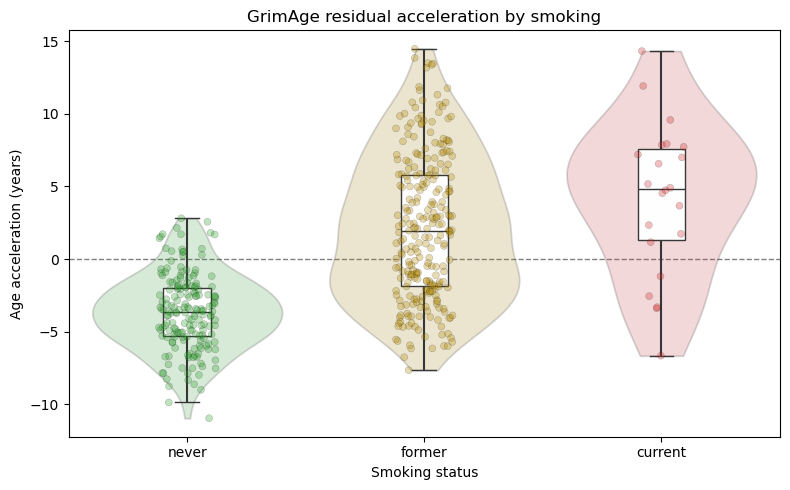

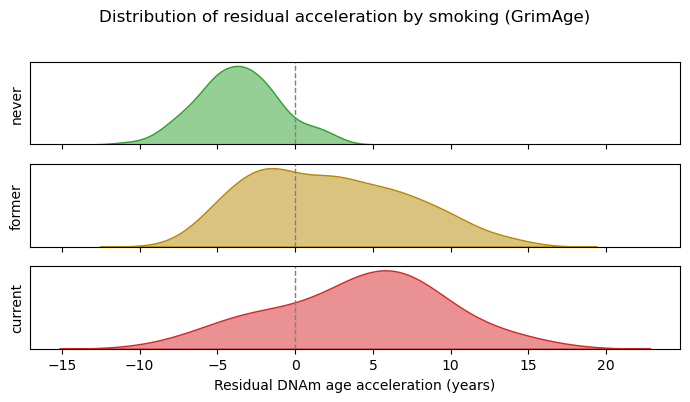

In [17]:
# Residual acceleration (recommended)
# Violin + box + scatter
fig, ax = plot_accel_violin(
    meta, "AgeAccel_GrimAge_resid", "GrimAge residual acceleration by smoking"
)
fig.savefig(os.path.join(save_dir, "grim_violin.png"), dpi=300, bbox_inches="tight")
fig.show()

# Ridgeline densities
fig, axes = plot_accel_ridgeline(
    meta, "AgeAccel_GrimAge_resid", "Distribution of residual acceleration by smoking (GrimAge)"
)
fig.savefig(os.path.join(save_dir, "grim_ridgeline.png"), dpi=300, bbox_inches="tight")
fig.show()

---
#### Statistical analysis (GrimAge)

As with Horvath v1, we compare smoking groups pairwise using Welch’s t-test (see explanation above). Here the goal is to formally test whether the differences in GrimAge acceleration observed in the plots are statistically significant.

The results confirm this: both former and current smokers show significantly higher acceleration than never smokers (p < 0.001, mean differences ≈ 6–8 years). However, the difference between former and current smokers is not statistically significant (p ≈ 0.10), indicating that GrimAge does not clearly separate these two groups.

In [18]:
res_grim = compare_groups_welch(meta, "AgeAccel_GrimAge_resid")
display(res_grim)

,comparison,n1,n2,mean_diff,CI95_lo,CI95_hi,Welch_p,Perm_p,Cliffs_delta,Holm_thresh,Reject@alpha
0,never vs former,179,263,-5.792,-6.509,-5.085,0.0000,0.0001,-0.682,0.0167,True
1,never vs current,179,22,-7.803,-9.982,-5.621,0.0000,0.0001,-0.789,0.0250,True
2,former vs current,263,22,-2.011,-4.165,0.265,0.0965,0.0725,-0.226,0.0500,False


---
#### Gardner–Altman estimation (GrimAge residual)

To highlight effect size and uncertainty, we show Gardner–Altman plots for the two comparisons with strong evidence of a difference (never vs former; never vs current). Each panel shows raw data (left) and the mean difference (Δ) with a bootstrap 95% CI (right). The dashed zero line marks “no difference”; CIs that do not cross zero indicate a robust shift.

We omit the former vs current comparison here because the estimated difference is smaller and the small current-smoker group (n = 22) limits power to detect subtle effects.

The plots make the findings clear:
- Both former and current smokers exhibit marked upward shifts relative to never smokers, with mean accelerations of ~6–8 years.
- The confidence intervals are narrow and fully above zero, reinforcing the statistical significance and robustness of these effects.
- Current smokers show a numerically larger acceleration than former smokers, but given the small sample size and wide variability, we cannot draw firm conclusions about a dose–response effect.

Together, these results show that GrimAge strongly captures smoking-related acceleration of biological aging, unlike Horvath v1.


/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/3022347184.py:222: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
/var/folders/qt/93c61j9d3ql3lshj9y7q4qdc0000gn/T/ipykernel_90691/1636498108.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


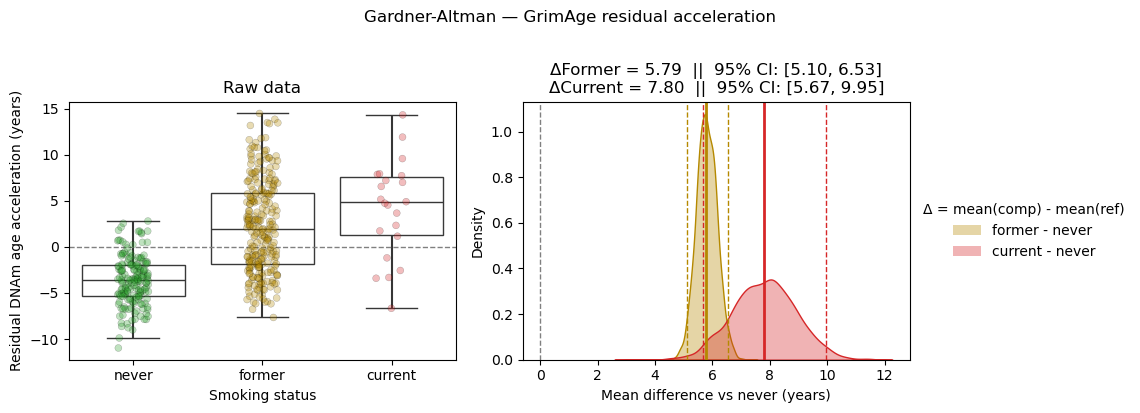

In [19]:
# Gardner–Altman estimation (GrimAge)
fig, (ax1, ax2) = plot_gardner_altman(
    meta,
    y_col="AgeAccel_GrimAge_resid",   # will fall back to 'AgeAccelGrim_resid' if needed
    ref="never",
    comps=("former", "current"),
    title="Gardner-Altman — GrimAge residual acceleration"
)
fig.savefig(os.path.join(save_dir, "grim_gardner_altman.png"), dpi=300, bbox_inches="tight")
fig.show()

---
#### Conclusion for GrimAge

Unlike Horvath v1, GrimAge reveals clear differences among smoking categories (residual acceleration).  

- **Never vs former smokers**: former smokers are on average ~5.8 years older epigenetically, highly significant (Welch’s *p* < 0.001). The Gardner–Altman plot confirms this shift, with ΔFormer = 5.79 years (95% CI: [5.10, 6.53]).  
- **Never vs current smokers**: current smokers show the strongest effect, ~7.8 years older on average, also highly significant (Welch’s *p* < 0.001). The Gardner–Altman plot indicates ΔCurrent = 7.80 years (95% CI: [5.67, 9.95]).  
- **Former vs current smokers**: the difference is smaller (~2 years) and not statistically significant.  

The violin and ridgeline plots already suggested these upward shifts, and the Gardner–Altman plots make the effect sizes and confidence intervals explicit.  

Together, these results demonstrate that GrimAge, unlike Horvath v1, is sensitive to smoking exposure and captures its impact on biological aging.



## Conclusion

Our analysis shows that the choice of aging model strongly determines whether smoking-related effects are detected.

Using Horvath v1, which was designed to track chronological age, neither simple nor residual acceleration measures revealed significant differences between smoking groups.

In contrast, GrimAge, trained to capture mortality risk and lifestyle-related factors, clearly distinguished never smokers from both former and current smokers, with substantial and statistically robust differences in residual acceleration.

Model selection is critical. An inappropriate choice (e.g., Horvath v1) can completely mask true biological effects. This underscores the importance of applying multiple aging clocks, each within its domain of applicability, to ensure robust and comprehensive insights.